In [20]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

In [21]:
emissions = pd.read_csv("D:\Kuliah\BasicStats\EVEN_FinalProj\datasets\API_EN.ATM.CO2E.PC_DS2_en_csv_v2_3159114.csv", skiprows=3)
country = pd.read_csv("D:\Kuliah\BasicStats\EVEN_FinalProj\datasets\GlobalLandTemperaturesByCountry.csv")

# processing the temperature dataset to only show Indonesia
country["dt"] = pd.to_datetime(country["dt"])
country.set_index("dt", inplace=True)
indo_temp = country.loc[country["Country"] == "Indonesia"] 
indo_temp.fillna(method="bfill", inplace=True)
indo_temp.drop("AverageTemperatureUncertainty", axis=1, inplace=True)
indo_temp = indo_temp.resample("AS").mean()
indo_temp 

# processing the CO2 emissions dataset to only show Indonesia
indo_emissions = emissions.loc[emissions["Country Name"] == "Indonesia"]
indo_emissions.drop("Unnamed: 65", axis=1, inplace=True)
# dropping the NaN values as it doesn't affect the analysis
indo_emissions.drop(["2019", "2020"], axis=1, inplace=True)

# slicing the dataframe to get usable features
indo_emissions = indo_emissions.iloc[:, 4:]
indo_emissions = indo_emissions.transpose()
indo_emissions.rename(columns={106:"CO2 emissions (metric tons per capita)"}, inplace=True)
indo_emissions.index = pd.to_datetime(indo_emissions.index)
 
# combining the two datasets together
# drop rows that don't have both features
indo_final = indo_temp.merge(indo_emissions, how='inner', left_on=indo_temp.index, right_on=indo_emissions.index)

# changing the datetime column name
indo_final.rename(columns={"key_0":"datetime"}, inplace=True)
indo_final

# setting the date to be the index
indo_final.set_index("datetime", inplace=True)
indo_final

,AverageTemperature,CO2 emissions (metric tons per capita)
datetime,,
1960-01-01,26.029167,0.243920
1961-01-01,25.771667,0.288848
1962-01-01,25.789417,0.248553
1963-01-01,25.838583,0.239783
1964-01-01,25.835500,0.229458
1965-01-01,25.701750,0.246241
1966-01-01,25.943917,0.227084
1967-01-01,25.835083,0.232007
1968-01-01,25.951083,0.253602


In [33]:
# since the missing values have been dealt with, proceed to check stationarity of the time series
# using the hoan test to determine to check the stationarity
# checking the eigenvalues of the dataset, zero eigenvalue means that the dataset is not cointegrated
# checking the first eigenvalue
johan_test_temp = indo_final.drop(["AverageTemperature"], axis=1)
johan_test_temp_2 = indo_final.drop(["CO2 emissions (metric tons per capita)"], axis=1)
print(coint_johansen(johan_test_temp,-1,1).eig)
print(coint_johansen(johan_test_temp_2,-1,1).eig)

# creating the train and test set
# the last 5 years of the dataset will be the test set
train = indo_final.iloc[0:49]
test = indo_final.iloc[49:]

# fitting the model
model = VAR(endog=train)
model_fit = model.fit()
prediction = model_fit.forecast(model_fit.y, steps=len(test))

# converting into dataframe
cols = indo_final.columns
pred = pd.DataFrame(index=range(0, len(prediction)), columns=[cols])
for j in range(0, 2):
    for i in range(0, len(prediction)):
        pred.iloc[i][j] = prediction[i][j]

# check rmse
for i in cols:
    print("RMSE value for", i, "is: ", math.sqrt(mean_squared_error(pred[i], test[i])))

[0.11854977]
[0.00645709]
  AverageTemperature CO2 emissions (metric tons per capita)
0                NaN                                    NaN
1                NaN                                    NaN
2                NaN                                    NaN
3                NaN                                    NaN
4                NaN                                    NaN
RMSE value for AverageTemperature is:  0.1411846253892145
RMSE value for CO2 emissions (metric tons per capita) is:  0.14220450875694624


In [37]:
# fitting the model on the dataset
# forecasting the value for the next 10 years
model = VAR(endog=indo_final)
model_fit = model.fit()
y_pred = model_fit.forecast(model_fit.y, steps=11)
print(y_pred)

[[26.46571334  1.84572475]
 [26.47862099  1.88643882]
 [26.49303162  1.9275043 ]
 [26.50773746  1.96903198]
 [26.52262513  2.01103735]
 [26.53768561  2.05352688]
 [26.55291983  2.09650626]
 [26.56832969  2.13998113]
 [26.58391721  2.18395721]
 [26.59968443  2.22844028]
 [26.61563343  2.27343619]]


In [51]:
# adding the predictions into the dataset
forecasted_temp = pd.DataFrame(index=(pd.date_range(start="2014-01-01", periods=11, freq="AS")), columns=[cols])
for j in range(0, 2):
    for i in range(0, len(y_pred)):
        forecasted_temp.iloc[i][j] = y_pred[i][j]

forecasted_temp

,AverageTemperature,CO2 emissions (metric tons per capita)
2014-01-01,26.465713,1.845725
2015-01-01,26.478621,1.886439
2016-01-01,26.493032,1.927504
2017-01-01,26.507737,1.969032
2018-01-01,26.522625,2.011037
2019-01-01,26.537686,2.053527
2020-01-01,26.55292,2.096506
2021-01-01,26.56833,2.139981
2022-01-01,26.583917,2.183957
2023-01-01,26.599684,2.22844


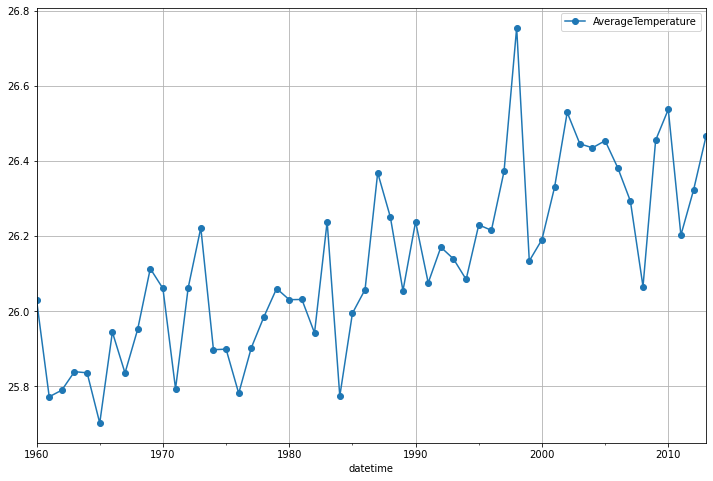

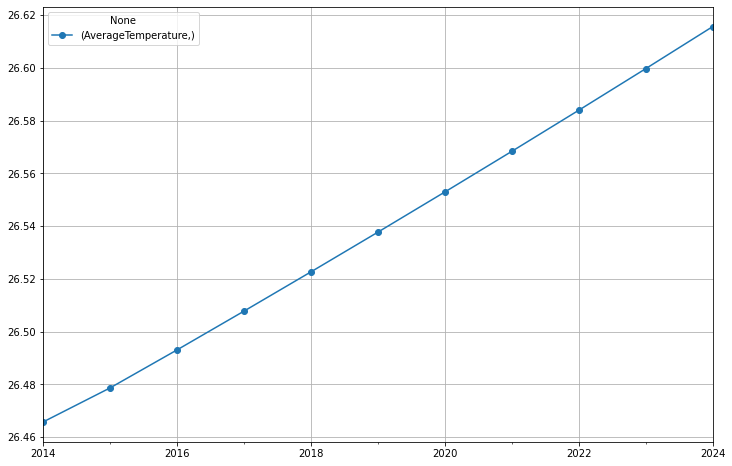

In [66]:
# plotting the forecast
indo_final.drop(["CO2 emissions (metric tons per capita)"], axis=1).plot(figsize=(12, 8), marker='o')
plt.grid()
forecasted_temp.drop(["CO2 emissions (metric tons per capita)"], axis=1).plot(figsize=(12, 8), marker='o')
plt.grid()